# Table of Contents
* [1a. Periodic spinodal decomposition on a square domain](#1a.-Periodic-spinodal-decomposition-on-a-square-domain)
	* [Define $f_0$](#Define-$f_0$)
	* [Define the Equation](#Define-the-Equation)
	* [Solve the Equation](#Solve-the-Equation)
	* [Run the Example Locally](#Run-the-Example-Locally)
	* [Movie of Evolution](#Movie-of-Evolution)


# 1a. Periodic spinodal decomposition on a square domain

The free energy is given by,

$$ f_0\left[ c \left( \vec{r} \right) \right] =
   - \frac{A}{2} \left(c - c_m\right)^2
   + \frac{B}{4} \left(c - c_m\right)^4
   + \frac{c_{\alpha}}{4} \left(c - c_{\alpha} \right)^4
   + \frac{c_{\beta}}{4} \left(c - c_{\beta} \right)^4 $$

In FiPy we write the evolution equation as 

$$ \frac{\partial c}{\partial t} = \nabla \cdot  \left[
       D \left( c \right) \left( \frac{ \partial^2 f_0 }{ \partial c^2} \nabla c - \kappa \nabla \nabla^2 c \right)
   \right] $$

Let's start by calculating $ \frac{ \partial^2 f_0 }{ \partial c^2} $ using sympy. It's easy for this case, but useful in the general case for taking care of difficult book keeping in phase field problems.

In [26]:
%matplotlib inline

import sympy
import fipy as fp
import numpy as np

In [27]:
c, rho_s, c_alpha, c_beta = sympy.symbols("c_var rho_s c_alpha c_beta")

In [28]:
f_0 = rho_s * (c - c_alpha)**2 * (c_beta - c)**2

In [29]:
print f_0

rho_s*(-c_alpha + c_var)**2*(c_beta - c_var)**2


In [30]:
sympy.diff(f_0, c, 2)

2*rho_s*((c_alpha - c_var)**2 + 4*(c_alpha - c_var)*(c_beta - c_var) + (c_beta - c_var)**2)

The first step in implementing any problem in FiPy is to define the mesh. For [Problem 1a]({{ site.baseurl }}/hackathon1/#a.-Square-Periodic) the solution domain is just a square domain, but the boundary conditions are periodic, so a `PeriodicGrid2D` object is used. No other boundary conditions are required.

In [31]:
mesh = fp.PeriodicGrid2D(nx=50, ny=50, dx=1.0, dy=1.0)

The next step is to define the parameters and create a solution variable.

In [41]:
c_alpha = 0.3
c_beta = 0.7
kappa = 2.0
M = 5.0
c_0 = 0.5
epsilon = 0.01
rho_s = 5.0

c_var = fp.CellVariable(mesh=mesh, name=r"$c$", hasOld=True)

Now we need to define the initial conditions given by,

Set $c\left(\vec{r}, t\right)$ such that

$$ c\left(\vec{r}, 0\right) = \bar{c}_0 + \epsilon \cos \left( \vec{q} \cdot \vec{r} \right) $$

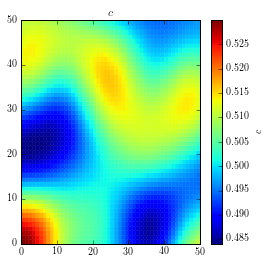

In [43]:
x , y = np.array(mesh.x), np.array(mesh.y)

c_var[:] = c_0 + epsilon * (np.cos(0.105 * x) * np.cos(0.11 * y) + \
                            (np.cos(0.13 * x) * np.cos(0.087 * y))**2 + \
                            + np.cos(0.025 * x - 0.15 * y) * np.cos(0.07 * x - 0.02 * y))

viewer = fp.Viewer(c_var)

## Define $f_0$

To define the equation with FiPy first define `f_0` in terms of FiPy. Recall `f_0` from above calculated using Sympy. Here we use the string representation and set it equal to `f_0_var` using the `exec` command.

In [44]:
out = sympy.diff(f_0, c, 2)

In [45]:
exec "f_0_var = " + repr(out)

In [46]:
#f_0_var = -A + 3*B*(c_var - c_m)**2 + 3*c_alpha*(c_var - c_alpha)**2 + 3*c_beta*(c_var - c_beta)**2
f_0_var

((((pow((0.3 - $c$), 2)) + (((0.3 - $c$) * 4) * (0.7 - $c$))) + (pow((0.7 - $c$), 2))) * 10.0)

## Define the Equation

In [47]:
eqn = fp.TransientTerm(coeff=1.) == fp.DiffusionTerm(M * f_0_var) - fp.DiffusionTerm((M, kappa))
eqn

(TransientTerm(coeff=1.0) + (DiffusionTerm(coeff=[-((((((pow((0.3 - $c$), 2)) + (((0.3 - $c$) * 4) * (0.7 - $c$))) + (pow((0.7 - $c$), 2))) * 10.0) * 5.0))]) + DiffusionTerm(coeff=[5.0, 2.0])))

## Solve the Equation

To solve the equation a simple time stepping scheme is used which is decreased or increased based on whether the residual decreases or increases. A time step is recalculated if the required tolerance is not reached.

In [50]:
elapsed = 0.0
steps = 0
dt = 0.01
total_sweeps = 2
tolerance = 1e-1
total_steps = 200
duration = 1000.0

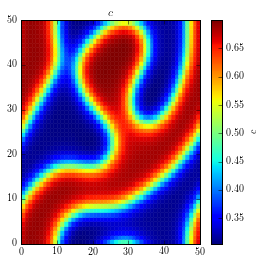

elapsed_time: 51.2926044873


In [51]:
c_var[:] = c_0 + epsilon * (np.cos(0.105 * x) * np.cos(0.11 * y) + \
                            (np.cos(0.13 * x) * np.cos(0.087 * y))**2 + \
                            + np.cos(0.025 * x - 0.15 * y) * np.cos(0.07 * x - 0.02 * y))
c_var.updateOld()
from fipy.solvers.pysparse import LinearLUSolver as Solver
solver = Solver()

while elapsed < duration and steps < total_steps:
    res0 = eqn.sweep(c_var, dt=dt, solver=solver)

    for sweeps in range(total_sweeps):
        res = eqn.sweep(c_var, dt=dt, solver=solver)

    if res < res0 * tolerance:
        steps += 1
        elapsed += dt
        dt *= 1.1
        c_var.updateOld()
    else:
        dt *= 0.8
        c_var[:] = c_var.old

viewer.plot()
print 'elapsed_time:',elapsed

## Run the Example Locally

The following cell will dumpy a file called `fipy_hackathon1a.py` to the local file system to be run. The images are saved out at each time step.

In [54]:
%%writefile fipy_hackathon_1a.py

import fipy as fp
import numpy as np

mesh = fp.PeriodicGrid2D(nx=400, ny=400, dx=0.5, dy=0.5)

c_alpha = 0.05
c_beta = 0.95
A = 2.0
kappa = 2.0
c_m = (c_alpha + c_beta) / 2.
B = A / (c_alpha - c_m)**2
D = D_alpha = D_beta = 2. / (c_beta - c_alpha)
c_0 = 0.45
q = np.sqrt((2., 3.))
epsilon = 0.01

c_var = fp.CellVariable(mesh=mesh, name=r"$c$", hasOld=True)

r = np.array((mesh.x, mesh.y))
c_var[:] = c_0 + epsilon * np.cos((q[:, None] * r).sum(0))

f_0_var = -A + 3*B*(c_var - c_m)**2 + 3*c_alpha*(c_var - c_alpha)**2 + 3*c_beta*(c_var - c_beta)**2

eqn = fp.TransientTerm(coeff=1.) == fp.DiffusionTerm(D * f_0_var) - fp.DiffusionTerm((D, kappa))

elapsed = 0.0
steps = 0
dt = 0.01
total_sweeps = 2
tolerance = 1e-1
total_steps = 1000

c_var[:] = c_0 + epsilon * np.cos((q[:, None] * r).sum(0))

c_var.updateOld()

from fipy.solvers.pysparse import LinearLUSolver as Solver

solver = Solver()

viewer = fp.Viewer(c_var)
while steps < total_steps:
    res0 = eqn.sweep(c_var, dt=dt, solver=solver)

    for sweeps in range(total_sweeps):
        res = eqn.sweep(c_var, dt=dt, solver=solver)

        print ' '
        print 'steps',steps
        print 'res',res
        print 'sweeps',sweeps
        print 'dt',dt


    if res < res0 * tolerance:
        steps += 1
        elapsed += dt
        dt *= 1.1
        if steps % 1 == 0:
             viewer.plot('image{0}.png'.format(steps))
        c_var.updateOld()
    else:
        dt *= 0.8
        c_var[:] = c_var.old

Writing fipy_hackathon_1a.py


## Movie of Evolution

The movie of the evolution for 900 steps.

The movie was generated with the output files of the form `image*.png` using the following commands,

    $ rename 's/\d+/sprintf("%05d",$&)/e' image*
    $ ffmpeg -f image2 -r 6 -i 'image%05d.png' output.mp4

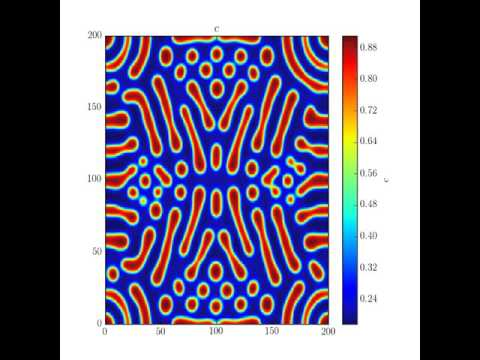

In [1]:
from IPython.display import YouTubeVideo
scale = 1.5
YouTubeVideo('t3tMYp806E4', width=420 * scale, height=315 * scale, rel=0)